In [80]:
import wfdb
import matplotlib.pyplot as plt
import numpy as np
import os

In [81]:
path = 'mit-bih-arrhythmia-database-1.0.0/'
record_name = '100'
path_with_no_extension = path + record_name
record = wfdb.rdrecord(path_with_no_extension)
annotation = wfdb.rdann(path_with_no_extension, 'atr')

Extraigo lo necesario de record 

In [82]:
fs = record.fs # f de muestreo
n_canales = record.n_sig # cant canales 
name_canales = record.sig_name #derivacion en cada canal 
units_canales = record.units # unidades de cada canal 
signal = record.p_signal #senal, cada muestra tiene valores de cada canal 
len = record.sig_len # largo deber ser como shape de signal 
record_name = record.record_name #nombre archivo ej 100



Extraigo lo necesario de annotaton 


In [156]:
channel_anno = annotation.chan # me dice cada anotacion a que canal pertenece (normalmente es a uno solo)
anno_len = annotation.ann_len
anno_sample_list = annotation.sample # es una lisa que tiene las muestras a la cual pertenece cada anno, ej 18 seria que pertenece a la muestra numero 18 de record.psignal
anno_symbol = annotation.symbol # es una lista de simbolos que corresponde a cada sample de annotation.sample, ej la sample 18 es N
#armo una lista de los simbolos difrentes 
unique_symbols = set(anno_symbol)





#### Lista del significado de los simbolos
- N : Normal beat
- L : Left bundle branch block beat
- R : Right bundle branch block beat
- A : Atrial premature beat
- V : Premature ventricular contraction
- F : Fusion of ventricular and normal beat
- / : Paced beat
- Q : Unclassifiable beat
- ! : Ventricular flutter wave
- E : Ventricular escape beat
- e : Atrial escape beat
- j : Nodal (junctional) escape beat
- S : Supraventricular premature beat
- J : Nodal (junctional) premature beat
- x : Non-conducted P-wave (blocked APB)
- f : Fusion of paced and normal beat
- p : Premature or ectopic supraventricular beat

In [84]:
df = record.to_dataframe()

In [94]:
len/fs

1805.5555555555557

In [92]:
df

,MLII,V5
0 days 00:00:00,-0.145,-0.065
0 days 00:00:00.002777777,-0.145,-0.065
0 days 00:00:00.005555554,-0.145,-0.065
0 days 00:00:00.008333331,-0.145,-0.065
0 days 00:00:00.011111108,-0.145,-0.065
...,...,...
0 days 00:30:05.541161115,-0.075,-0.480
0 days 00:30:05.543938892,-0.445,-0.410
0 days 00:30:05.546716669,-0.675,-0.365
0 days 00:30:05.549494446,-0.765,-0.335


#### Creo lista de tiempo 

In [139]:
#desde muestra i a muestra f 

muestra_i = 0
muestra_f = len * 1/100
# lo paso al tiempo
t0 = muestra_i/fs
tf = muestra_f/fs
#creo array de ti a tf separado por el periodo de muestreo 1/fs
time_line = np.arange(start= t0, stop= tf, step= 1/fs)



### Parametros que tiene este archivo

In [140]:
print(f'el archivo {record_name} cuenta con {n_canales} los cuales tienes la derivaciones {name_canales} en las unidades {units_canales}')

el archivo 100 cuenta con 2 los cuales tienes la derivaciones ['MLII', 'V5'] en las unidades ['mV', 'mV']


### Creo porcion de señal a mostrar


In [154]:
channel = 0 #elijo que derivacion plotear 
grath_signal = signal[int(muestra_i):int(muestra_f),channel]



### Plot ECG

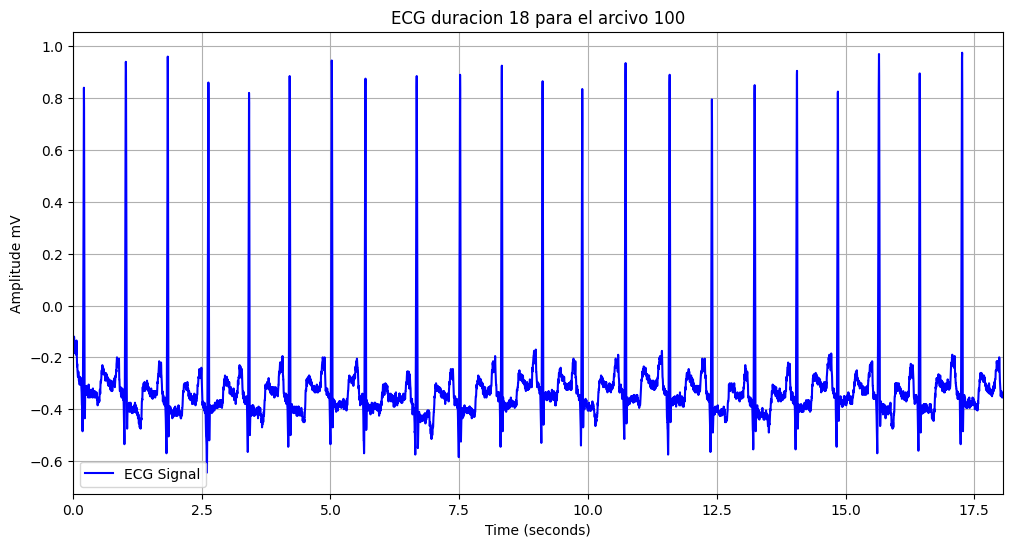

In [145]:
# Plotting the ECG signal
plt.figure(figsize=(12, 6))
plt.plot(time_line, grath_signal, label='ECG Signal', color='b')
plt.title(f'ECG duracion {round(tf - t0)} para el arcivo {record_name}')
plt.xlabel('Time (seconds)')
plt.ylabel(f'Amplitude {units_canales[channel]}')
plt.xlim(t0, tf)  # Set the x-axis limits
plt.grid()
plt.legend()
plt.show()

### Creo lista de anotaciones 

In [218]:
anno_sample_grath = []
flag = 0
min_index_anno_sample = None

for index,sample in enumerate(anno_sample_list):
    if muestra_i <= sample <= muestra_f:
        anno_sample_grath.append(sample)
        if flag == 0:
            min_index_anno_sample = index
            flag = 1
            
anno_sample_grath_len = np.shape(anno_sample_grath)[0]
print(anno_sample_grath)
print(min_index_anno_sample)
       

[18, 77, 370, 662, 946, 1231, 1515, 1809, 2044, 2402, 2706, 2998, 3282, 3560, 3862, 4170, 4466, 4764, 5060, 5346, 5633, 5918, 6214]
0


In [224]:
plot_anno_sample =  np.zeros(int(muestra_f- muestra_i))
for index,sample in enumerate(plot_anno_sample):
    if index in (anno_sample_grath):
        plot_anno_sample[index] = 1
    
# es un array del mismo largo que la time list y signal. Pero tiene el valor de signal donde va una anotacion. es decir es 0 si no va nada y signal si si  


1.0


### creo una lista de los simbolos de anotacciones 

In [225]:
anno_symbol_grath = anno_symbol[min_index_anno_sample:anno_sample_grath_len]
if anno_sample_grath_len != np.shape(anno_symbol_grath)[0]:
      raise Exception("Problema no es el mismo largo el de nno_sample_grath_len y anno_symbol_grath ")


In [238]:
plot_anno_symbol = [None for _ in range(int(muestra_f- muestra_i))]
contador = 0
for index, sample in enumerate(plot_anno_sample):
    if sample != 0:
        plot_anno_symbol[index] = anno_symbol_grath[contador]
        contador +=1 
# plot anno symol es una lista de tama;o time line y grath signal que tiene los simbolos en su respectiva posicion 


In [170]:
print(f'los simbolos posibles para este archivo son {unique_symbols }')

los simbolos posibles para este archivo son {'V', '+', 'N', 'A'}


In [196]:
def get_annotation_colors(symbols):
    colors = []
    for symbol in symbols:
        if symbol == 'N':  # Latido normal
            colors.append('orange')
        elif symbol == 'L':  # Bloqueo de rama izquierda
            colors.append('blue')
        elif symbol == 'R':  # Bloqueo de rama derecha
            colors.append('purple')
        elif symbol == 'A':  # Latido prematuro auricular
            colors.append('pink')
        elif symbol == 'V':  # Contracción ventricular prematura
            colors.append('red')
        elif symbol == 'F':  # Fusión de latidos ventriculares y normales
            colors.append('yellow')
        elif symbol == '/':  # Latido con marcapasos
            colors.append('cyan')
        elif symbol == 'Q':  # Latido inclasificable
            colors.append('black')
        elif symbol == '!':  # Onda de aleteo ventricular
            colors.append('magenta')
        elif symbol == 'E':  # Latido de escape ventricular
            colors.append('darkred')
        elif symbol == 'e':  # Latido de escape auricular
            colors.append('lightgreen')
        elif symbol == 'j':  # Latido de escape nodal (de la unión)
            colors.append('lightblue')
        elif symbol == 'S':  # Latido prematuro supraventricular
            colors.append('darkgreen')
        elif symbol == 'J':  # Latido prematuro nodal (de la unión)
            colors.append('brown')
        elif symbol == 'x':  # P-onda no conducida (bloqueo APB)
            colors.append('gray')
        elif symbol == 'f':  # Fusión de latido normal y con marcapasos
            colors.append('lightyellow')
        elif symbol == 'p':  # Latido prematuro o ectópico supraventricular
            colors.append('darkblue')
        else:  # Otros tipos de anotaciones no definidos
            colors.append('green')
    return colors

In [203]:
# Definir la correspondencia entre símbolos, descripciones y colores
symbol_descriptions = {
    'N': 'Normal beat',
    'L': 'Left bundle branch block beat',
    'R': 'Right bundle branch block beat',
    'A': 'Atrial premature beat',
    'V': 'Premature ventricular contraction',
    'F': 'Fusion of ventricular and normal beat',
    '/': 'Paced beat',
    'Q': 'Unclassifiable beat',
    '!': 'Ventricular flutter wave',
    'E': 'Ventricular escape beat',
    'e': 'Atrial escape beat',
    'j': 'Nodal (junctional) escape beat',
    'S': 'Supraventricular premature beat',
    'J': 'Nodal (junctional) premature beat',
    'x': 'Non-conducted P-wave (blocked APB)',
    'f': 'Fusion of paced and normal beat',
    'p': 'Premature or ectopic supraventricular beat'
}

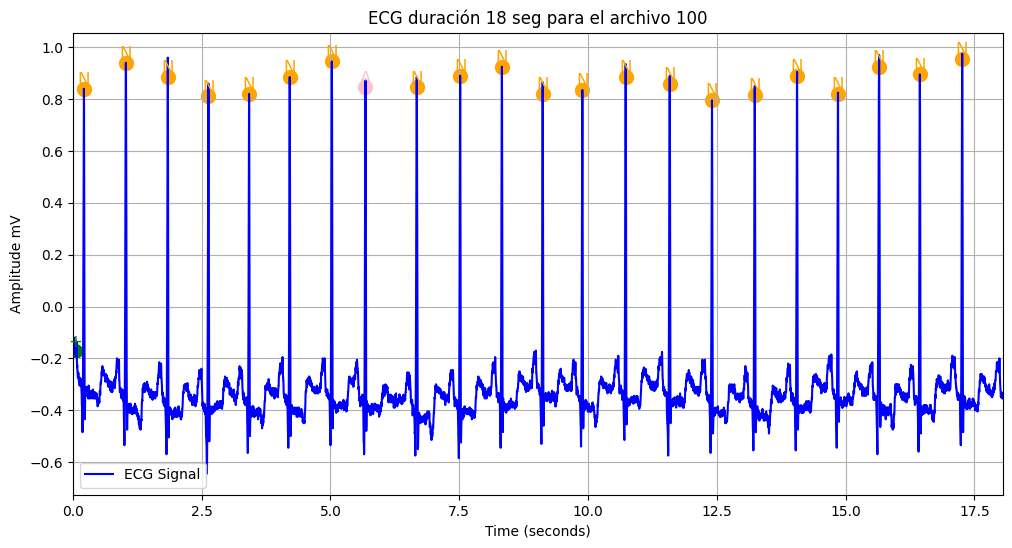

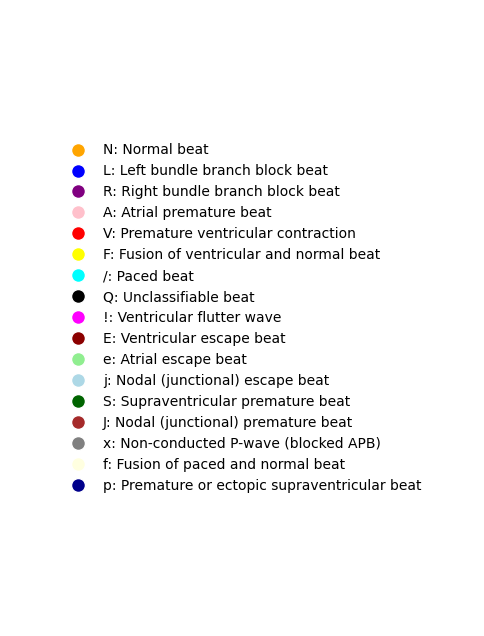

In [235]:
# Obtenemos los colores para los símbolos de las anotaciones
annotation_colors = get_annotation_colors(plot_anno_symbol)

# Gráfico del ECG
plt.figure(figsize=(12, 6))
plt.plot(time_line, grath_signal, label='ECG Signal', color='b')
plt.title(f'ECG duración {round(time_line[-1])} seg para el archivo {record_name}')
plt.xlabel('Time (seconds)')
plt.ylabel(f'Amplitude {units_canales[0]}')
plt.xlim(time_line[0], time_line[-1])
plt.grid()
plt.legend()

# Añadir anotaciones con colores y símbolos
for i, symbol in enumerate(plot_anno_symbol):
    if symbol is not None:  # Si hay una anotación
        # Añadir el punto de color
        plt.scatter(time_line[i], grath_signal[i], color=annotation_colors[i], label=symbol, s=100)
        # Añadir el texto del símbolo en la misma posición
        plt.text(time_line[i], grath_signal[i], symbol, color=annotation_colors[i], fontsize=12, 
                 verticalalignment='bottom', horizontalalignment='center')

plt.show()



# Extraer los colores para la leyenda
unique_symbols = list(symbol_descriptions.keys())
unique_colors = get_annotation_colors(unique_symbols)

# Crear el plot solo para la leyenda
fig, ax = plt.subplots(figsize=(6, 8))  # Tamaño ajustado para la leyenda
ax.axis('off')  # Ocultar los ejes, solo queremos la leyenda

# Añadir los elementos de la leyenda
legend_elements = []
for symbol, color in zip(unique_symbols, unique_colors):
    legend_elements.append(plt.Line2D([0], [0], marker='o', color='w', label=f'{symbol}: {symbol_descriptions[symbol]}',
                                      markerfacecolor=color, markersize=10))

# Colocar la leyenda en el gráfico vacío
ax.legend(handles=legend_elements, loc='center', frameon=False)  # `loc='center'` para centrar la leyenda

# Mostrar el gráfico que contiene solo la leyenda
plt.show()